In [1]:
# first, some imports to get that out of the way...
import gud
import numpy as np
import matplotlib.pyplot as plt
from flax import nnx
import jax
import jax.numpy as jnp
import bijx

rngs = nnx.Rngs(0)

In [2]:
from utils import MNIST

# load fashion mnist as example data
dataset = MNIST(dataset='fashion-mnist')

# Generation with Unified Diffusion

We explore the degrees of freedom we have in a diffusion model setup where we require that we have a simple element-wise Ornstein-Uhlenbeck process, but possibly in a different *data representation* (or basis) than the original data.

Let's say $\phi$ is our initial data, e.g. an image. However, we think of this as a vector now.

We then define the basis transformation as $\hat{\chi} = M \phi$ where $M$ is initially any invertible matrix.
To add interpretability, we decompose $M = S^{-1} U$ where $S$ is a diagonal matrix and $U$ is orthogonal (or unitary).

The hat on $\chi$ indicates whitening, but it strictly does not have to whiten the data.
The term is still suggestive as we will define the "standard" diffusion process in this space where we add white noise, and thus at least at large times $\hat{\chi}(t)$ will become white noise.

Thus we have the following spaces
$$
\textbf{data: } \phi 
\; \xrightarrow{\text{to\_component\_space}} \;
\textbf{comp: } \chi = U \phi 
\; \xrightarrow{\text{whiten}} \;
\textbf{comp\_white: } \hat{\chi} = S^{-1} \chi
\; \xrightarrow{\text{to\_data\_space}} \;
\textbf{data\_white: } \hat \phi = U^\dagger \hat{\chi}
$$






## Shape conventions

To make the code (and reasoning about it) easier, we flatten spacial components into a single dimension.
In addition to this "spatial" index, we consider additionally a final "channel" dimension, as well as (of course) a batch dimension.

The idea of the final "channel" index is that we broadcast all operations over this.
The operation $U$ etc. are just vectorized, i.e. applied equally for each channel.

This is no sacrafice in generality.
For example, for images of shape `(32, 32, 3)` we could choose to apply the same operation per color channel and flatten to `(32 * 32, 3)`.
On the other hand, if our transformation should mix color channels, we could flatten to `(32 * 32 * 3, 1)`.

## Space conversions

There are several ways to convert between the spaces.

The most basic one is to use the methods `encode` and `decode` that each space implements and converts between $\phi$ and $\hat \chi$. These are composed of the more basic `whiten`, `to_component_space`, etc.

The other hopefully even simpler way is to wrap things in `Data` or `Score` (the latter is necessary because the score transforms differently than the data).

(64, 784, 1)


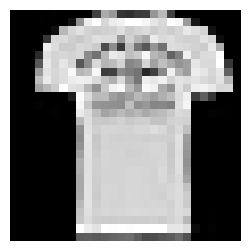

In [3]:
# this is the "dummy" space where U=1 and S=1
space = gud.Space()

# load next batch of data as an example
x, _ = dataset.next()
print(x.shape)

plt.figure(figsize=(3, 3))
plt.imshow(x[0].reshape(28, 28), cmap='gray', interpolation='none')
plt.axis('off')
plt.show()

In [4]:
# wrap data in Data object, indicating what space it is in
data = space.wrap(data=x)

# can now access in other representations (lazily compputed and stored in place)
data.comp_white.shape

(64, 784, 1)

In [5]:
# equivalent construction of data from whitened components
data = space.wrap(comp_white=x)

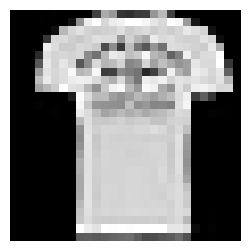

In [6]:
# right now, of course, the space isn't doing anything
plt.figure(figsize=(3, 3))
plt.imshow(data.comp_white[0].reshape(28, 28), cmap='gray', interpolation='none')
plt.axis('off')
plt.show()

# Basic schedule

In [7]:
# gamma_min and _max set the "end points" of the schedule, here linear-gamma schedule
schedule = gud.linear_schedule(gamma_min=-9, gamma_max=5)

# evaluating the schedule at some time returns a "noising state" variable
t = 0.3
ns = schedule(t)
ns.sigma

Array(0.09034696, dtype=float32, weak_type=True)

In [8]:
# passing "shape" broadcasts the noising state to the data shape for convenience
# in the "per-component" schedules
ns = schedule(t, shape=data.shape)
ns.sigma.shape

(64, 784, 1)

In [9]:
# noise data, z is the noise that was added
x_noised, z = gud.ou_process(rngs(), data, ns)

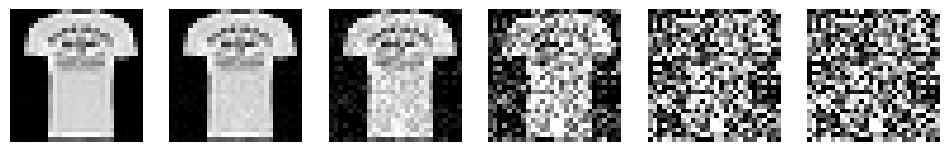

In [10]:
# visualize noising over time for a fixed sample

# the noise at different times should strictly come from one brownian motion
# but for simplicity we fix the rng here
noise_rng = rngs()

plt.figure(figsize=(12, 3))
for i, t in enumerate(np.linspace(0, 1, 6)):
    plt.subplot(1, 6, i + 1)

    ns = schedule(t, shape=x.shape)
    x_noised, z = gud.ou_process(noise_rng, data, ns)

    plt.imshow(x_noised.data[0].reshape(28, 28), cmap="gray", vmin=-1, vmax=1)
    plt.axis('off')

plt.show()

# FFT Space

In [11]:
@jax.jit
def compute_fft_stats(data):
    data = data.reshape(-1, 28, 28)
    mean = data.mean(axis=0)
    data_fft = jnp.fft.fft2(data - mean, axes=(1, 2), norm='ortho')
    variance = jnp.mean(jnp.abs(data_fft)**2, axis=0)

    return mean.flatten(), variance.flatten()

In [12]:
mean_fft, var_fft = compute_fft_stats(dataset.images)

In [13]:
# save for reuse in training notebook
np.savez('datasets/fft_stats.npz', mean_fft=mean_fft, var_fft=var_fft)

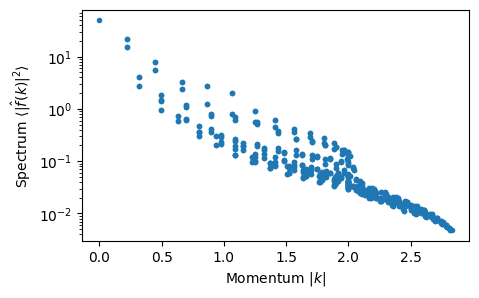

In [14]:
# get momenta variables
ks = jnp.linalg.norm(bijx.fourier.fft_momenta((28, 28), reduced=False, lattice=True), axis=-1).flatten()

# plot power spectrum as a function of momentum
plt.figure(figsize=(5, 3))
plt.semilogy(ks, var_fft, '.')
plt.xlabel(r"Momentum $|k|$")
plt.ylabel(r"Spectrum $\langle |\hat f(k)|^2 \rangle$")
plt.show()

## "True" SNR

Although PCA would be a more accurate approach here, as it diagonalizes the covariance matrix,
we can take FFT as an approximation (that becomes better the closer the dataset is to being translationally invariant).

Given that we now have the magnitude of each FFT component as measured by it's variance, we can analyze how much of the signal is left after some time of noising.

Note that it may not be necessary to reduce the final SNR of the lowest-frequency components to zero, as this component individually may be sufficiently close to univariate Gaussian.
If this was not the case, however, we should make sure to pick gamma-endpoints that inject sufficient noise at $t=1$.

[Also note that we cheat very slightly here in starting the schedule at gamma_min greater than $-\infty$. Formally, of course, if we have added no noise then the initial SNR at 0 should diverge!]

In [15]:
schedule = gud.linear_schedule(gamma_min=-9, gamma_max=5)

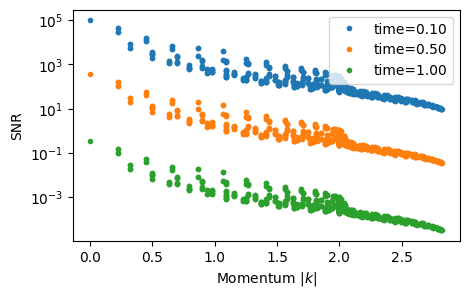

In [16]:
plt.figure(figsize=(5, 3))
t = 0.1
true_snr = var_fft * jnp.exp(-schedule(t).gamma)
plt.semilogy(ks, true_snr, '.', label=f'time={t:.2f}')

t = 0.5
true_snr = var_fft * jnp.exp(-schedule(t).gamma)
plt.semilogy(ks, true_snr, '.', label=f'time={t:.2f}')

t = 1.0
true_snr = var_fft * jnp.exp(-schedule(t).gamma)
plt.semilogy(ks, true_snr, '.', label=f'time={t:.2f}')

plt.xlabel(r"Momentum $|k|$")
plt.ylabel(r"SNR")
plt.legend()
plt.show()

We can see above that the varying magnitude in the data induces a faster reduction in SNR for higher-frequency components.
This is simply because their magnitude is already smaller, shifting the values downwards in log-space.

Before we go to whitened FFT space, we can also visualize the noising in Fourier components using an unwhitened FFT space.
Note that the low-frequency compoents in the image below are in the corners.

As $\gamma \to \infty$, we reach white noise which has a flat amplitude in both the original and in Fourier space.

In [17]:
space = gud.FourierSpace((28, 28))
schedule = gud.linear_schedule(gamma_min=-9, gamma_max=10)
data = space.wrap(data=x)

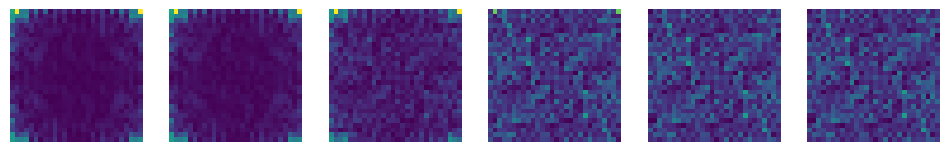

In [18]:
noise_rng = rngs()

plt.figure(figsize=(12, 3))
for i, t in enumerate(np.linspace(0, 1, 6)):
    plt.subplot(1, 6, i + 1)

    ns = schedule(t, shape=data.shape)
    x_noised, z = gud.ou_process(noise_rng, data, ns)

    plt.imshow(np.abs(x_noised.comp)[0].reshape(28, 28), cmap="viridis", vmax=5)
    plt.axis('off')

plt.show()

Let us now go to whitened FFT space.
The linear schedule in this space would add noise of the same power spectrum as the original data, thus noising all comoponents at the same rate.

In [19]:
space = gud.FourierSpace((28, 28), scale=jnp.sqrt(var_fft))
schedule = gud.linear_schedule(gamma_min=-9, gamma_max=5)

data = space.wrap(data=x)

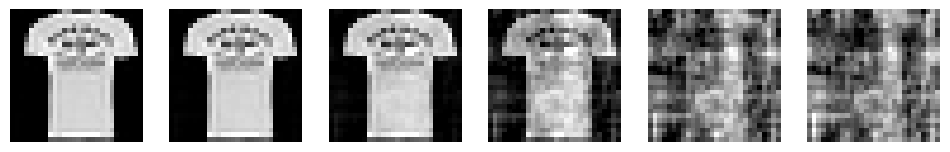

In [20]:
# visualize noising over time for a fixed sample

noise_rng = rngs()

plt.figure(figsize=(12, 3))
for i, t in enumerate(np.linspace(0, 1, 6)):
    plt.subplot(1, 6, i + 1)

    ns = schedule(t, shape=data.shape)
    x_noised, z = gud.ou_process(noise_rng, data, ns)

    plt.imshow(x_noised.data[0].reshape(28, 28), cmap="gray", vmin=-1, vmax=1)
    plt.axis('off')

plt.show()

Visualizing again the norm of the Fourier components, we can see that the "separation of scales" remains the same. 

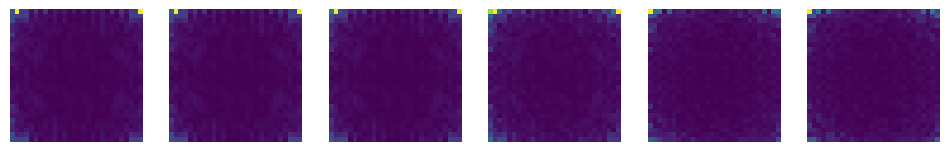

In [21]:
noise_rng = rngs()

plt.figure(figsize=(12, 3))
for i, t in enumerate(np.linspace(0, 1, 6)):
    plt.subplot(1, 6, i + 1)

    ns = schedule(t, shape=data.shape)
    x_noised, z = gud.ou_process(noise_rng, data, ns)

    plt.imshow(np.abs(x_noised.comp)[0].reshape(28, 28), cmap="viridis")
    plt.axis('off')

plt.show()

Since we perfrom the OU process on the whitened componnets, we do not get a "soft-autoregressive" generation in this case.

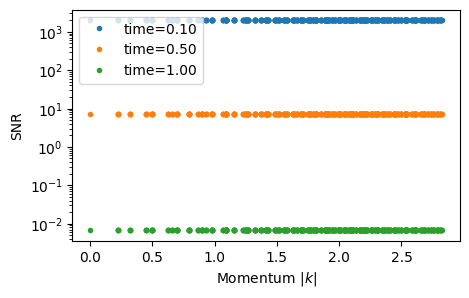

In [22]:
plt.figure(figsize=(5, 3))
t = 0.1
true_snr = np.ones_like(var_fft) * jnp.exp(-schedule(t).gamma)
plt.semilogy(ks, true_snr, '.', label=f'time={t:.2f}')

t = 0.5
true_snr = np.ones_like(var_fft) * jnp.exp(-schedule(t).gamma)
plt.semilogy(ks, true_snr, '.', label=f'time={t:.2f}')

t = 1.0
true_snr = np.ones_like(var_fft) * jnp.exp(-schedule(t).gamma)
plt.semilogy(ks, true_snr, '.', label=f'time={t:.2f}')

plt.xlabel(r"Momentum $|k|$")
plt.ylabel(r"SNR")
plt.legend()
plt.show()

## Component-wise schedule

We can recover the same effective SNR even with whitened components by using a component-wise schedule.

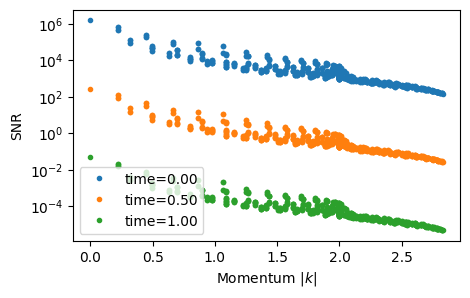

In [23]:
space = gud.FourierSpace((28, 28), scale=jnp.sqrt(var_fft))
labels = -np.log(var_fft)

schedule = gud.soft_conditioning_schedule(
    labels=labels,
    gamma_min_target=-5,
    gamma_max_target=3,
    # softness = 1 explicitly reconstructs the same hierarchy as "vanilla" diffusion
    softness=1,
    # we can clip the gamma endpoints so each component is truely noised and denoised
    # to the same SNRs
    # gamma_cap=(-5, 3)
)


plt.figure(figsize=(5, 3))
t = 0.0
true_snr = np.ones_like(var_fft) * jnp.exp(-schedule(t).gamma)
plt.semilogy(ks, true_snr, '.', label=f'time={t:.2f}')

t = 0.5
true_snr = np.ones_like(var_fft) * jnp.exp(-schedule(t).gamma)
plt.semilogy(ks, true_snr, '.', label=f'time={t:.2f}')

t = 1.0
true_snr = np.ones_like(var_fft) * jnp.exp(-schedule(t).gamma)
plt.semilogy(ks, true_snr, '.', label=f'time={t:.2f}')

plt.xlabel(r"Momentum $|k|$")
plt.ylabel(r"SNR")
plt.legend()
plt.show()

It can be more instructive to plot the schedule with noising time $t$ on the x-axis.

In [24]:
ts = np.linspace(0, 1, 100)
ns = schedule(ts)

# visualize each line (corresponding to different fourier components)
# using different colors with dark ~ low frequency, light ~ high frequency
cmap = plt.cm.magma
labels_unit = (labels - labels.min()) / (labels.max() - labels.min())

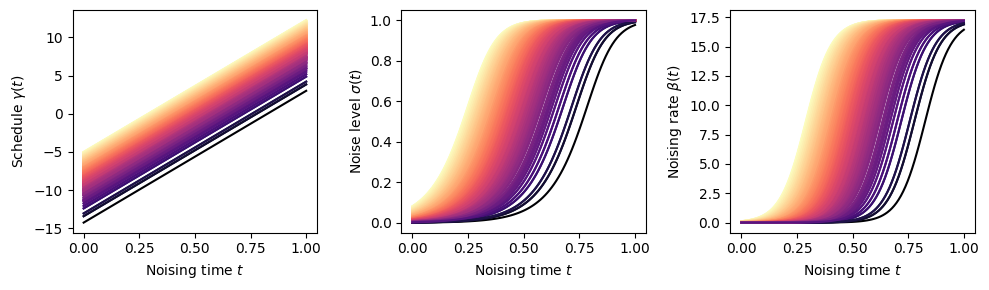

In [25]:
fig, axes = plt.subplots(1, 3, figsize=(10, 3))

# Plot gamma
for i in range(len(ks)):
    axes[0].plot(ts, ns.gamma[:, i], color=cmap(labels_unit[i]))
axes[0].set_xlabel(r"Noising time $t$")
axes[0].set_ylabel(r"Schedule $\gamma(t)$")

# Plot sigma
sigma = np.sqrt(jax.nn.sigmoid(ns.gamma))
for i in range(len(ks)):
    axes[1].plot(ts, sigma[:, i], color=cmap(labels_unit[i]))
axes[1].set_xlabel(r"Noising time $t$")
axes[1].set_ylabel(r"Noise level $\sigma(t)$")

# Plot beta
for i in range(len(ks)):
    axes[2].plot(ts, ns.beta[:, i], color=cmap(labels_unit[i]))
axes[2].set_xlabel(r"Noising time $t$")
axes[2].set_ylabel(r"Noising rate $\beta(t)$")

plt.tight_layout()
plt.show()

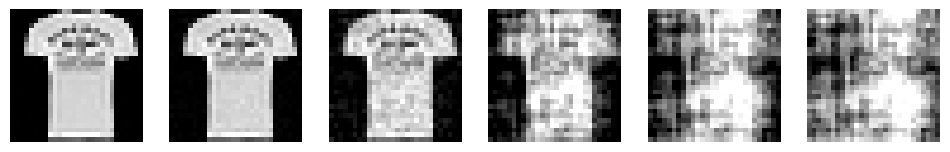

In [26]:
# visualize noising over time for a fixed sample

data = space.wrap(data=x)
noise_rng = rngs()

plt.figure(figsize=(12, 3))
for i, t in enumerate(np.linspace(0, 1, 6)):
    plt.subplot(1, 6, i + 1)

    ns = schedule(t, shape=data.shape)
    x_noised, z = gud.ou_process(noise_rng, data, ns)

    plt.imshow(x_noised.data[0].reshape(28, 28), cmap="gray", vmin=-1, vmax=1)
    plt.axis('off')

plt.show()

# Column-wise schedule

Perhaps the most intuitive "component-wise" schedule is to noising each column of the image independently.
Here we use the "trivial" Space() again, which corresponds to doing nothing (no scaling and no whitening).

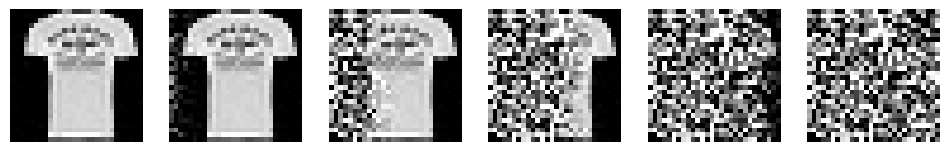

In [27]:
space = gud.Space()
schedule = gud.column_schedule(
    n_cols=28,
    n_rows=28,
    softness=1.5,
    gamma_min=-8,
    gamma_max=5,
)

data = space.wrap(data=x)
noise_rng = rngs()

# visualize noising over time for a fixed sample

data = space.wrap(data=x)
noise_rng = rngs()

plt.figure(figsize=(12, 3))
for i, t in enumerate(np.linspace(0, 1, 6)):
    plt.subplot(1, 6, i + 1)

    ns = schedule(t, shape=data.shape)
    x_noised, z = gud.ou_process(noise_rng, data, ns)

    plt.imshow(x_noised.data[0].reshape(28, 28), cmap="gray", vmin=-1, vmax=1)
    plt.axis('off')

plt.show()